This is version 2 of this project, which will focus only on customers that were not contacted previously. Months feature will not be taken into account, as some months featured close to no contacts with customers and if the bank decided to launch a campaign in one of these months, the model's performance would be compromised by the lack of data in the training dataset.

# 1. Import

In [1]:
# libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.datasets import fetch_openml


# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# data preparation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from feature_engine.outliers import Winsorizer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#visualization
from sklearn import set_config
set_config(display = 'text')
from sklearn.tree import plot_tree


Data obtained from [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

In [2]:
# data import
data = pd.read_csv('bank-full.csv', sep = ';')

# drop 'duration' column to avoid bias
data.drop('duration', axis = 'columns', inplace = True)

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


# 2 Data exploration and visualization

In [3]:
# to see the amount of data the dataset contains, its types and the names of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  y          45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


## 2.1 Categorical data


In [4]:
# Are there any missing data?
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

It seems that there are no missing data, so there is no need to fill them in.
However, the dataset page claims that there are columns in which one of the possible values is "unknown", which are esentially missing data.

In [5]:
for feature in data.select_dtypes('object'):
    print('Feature: ',feature, data[feature].unique())

Feature:  job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Feature:  marital ['married' 'single' 'divorced']
Feature:  education ['tertiary' 'secondary' 'unknown' 'primary']
Feature:  default ['no' 'yes']
Feature:  housing ['yes' 'no']
Feature:  loan ['no' 'yes']
Feature:  contact ['unknown' 'cellular' 'telephone']
Feature:  month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Feature:  poutcome ['unknown' 'failure' 'other' 'success']
Feature:  y ['no' 'yes']


When values in these columns are obsereved, the unknown value appear in the job, education, contact and poutcome columns. Let's see if they form a substantial part of the data.

In [6]:
# How many people did not provide these information?
data.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [7]:
na_job =len(data.query('job == "unknown"'))/len(data)
print(f'Unknown job is in {na_job:.2%} of the data')

Unknown job is in 0.64% of the data


In [8]:
data.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [9]:
na_education =len(data.query('education == "unknown"'))/len(data)
print(f'Unknown education is in {na_education:.2%} of the data')

Unknown education is in 4.11% of the data


The proportion of contacted people whose job or education is unknown isrelatively low (0,64 and 4.11 % respectively). 

In [10]:
df = (
    data
      .pivot_table(data, index = 'contact', columns = 'y', aggfunc = {'contact':'count'})
      .droplevel(0, axis = 1)
    .assign(positive_percent = lambda x: x['yes']/(x['no']+x['yes'])*100)
)
df

y,no,yes,positive_percent
contact,,,
cellular,24916,4369,14.918900
telephone,2516,390,13.420509
unknown,12490,530,4.070661


We can see that the groups that were contacted on cellular and on telephone have a similar proportion of positive responses, while the group about which we do not have this information is less likely to have a positive response. For this reason, the unknown values may be important.

In [11]:
# how many people were not contacted before
len(data.query('pdays == -1'))

36954

In [12]:
#outcome of previous campaign distribution
data['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [13]:
na_poutcome =len(data.query('poutcome == "unknown"'))/len(data)
print(f'Unknown previous outcome is in {na_poutcome:.2%} of the data')

Unknown previous outcome is in 81.75% of the data


In [14]:
data.query('poutcome == "unknown" & previous != 0')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
40658,61,retired,married,tertiary,no,3140,yes,yes,cellular,6,aug,4,98,1,unknown,yes
41821,39,management,married,tertiary,no,184,no,no,cellular,15,oct,1,168,5,unknown,no
42042,26,admin.,single,secondary,no,338,no,no,cellular,29,oct,1,188,2,unknown,yes
43978,30,technician,single,secondary,no,254,yes,yes,cellular,24,jun,3,416,2,unknown,no
45021,37,management,married,secondary,no,209,no,no,cellular,14,oct,3,528,7,unknown,no


As the majority of people were not contacted before, they have unknown value in the outcome of previous call. There are only 5 people who were contacted before and the previous outcome in unknown. As predicting the behavior of people who were not contacted before or who dismissed the offer previously is more valuable for the bank, the columns where previous result was success will be dropped

In [18]:
# only customers that were not contacted previously
data = data.query('previous == 0')

In [29]:
# pdays, previous and poutcome are related to previous campaigns so they are not necessary for this group
# so I'll drop the columns
data.drop(axis = 0, columns = ['pdays', 'previous', 'poutcome'], inplace = True)

As the job category is has many possible values, let's check if there are any rare values.

In [30]:
job_percent = (
    data['job']
    .value_counts(normalize = True)
    .mul(100)
)
job_percent
    

blue-collar      21.959734
management       20.652703
technician       16.926449
admin.           11.046166
services          9.330519
retired           4.805975
self-employed     3.512475
entrepreneur      3.415057
unemployed        2.949613
housemaid         2.944201
student           1.767062
unknown           0.690047
Name: job, dtype: float64

There are several jobs that do not make much of the dataset. I want to know if there is a pattern in how likely they are to accept the offer.

In [31]:
df = (
    data
    .pivot_table(index = 'job', columns = 'y', aggfunc={'y': 'count'})
    .droplevel(0, axis = 1)
    .assign(positive_percent = lambda x: x['yes']/(x['no']+x['yes'])*100)
    .assign(job_type_percent = job_percent)
    .sort_values('job_type_percent', ascending = False)
)
df

y,no,yes,positive_percent,job_type_percent
job,,,,
blue-collar,7591,524,6.457178,21.959734
management,6853,779,10.207023,20.652703
technician,5697,558,8.920863,16.926449
admin.,3700,382,9.358158,11.046166
services,3198,250,7.250580,9.330519
retired,1466,310,17.454955,4.805975
self-employed,1176,122,9.399076,3.512475
entrepreneur,1166,96,7.606973,3.415057
unemployed,970,120,11.009174,2.949613


From this table, it is visible that there are big differences based on job type in whether the person accepted the offer or not. For this reason, I will not use RareLabelEncoder for now.

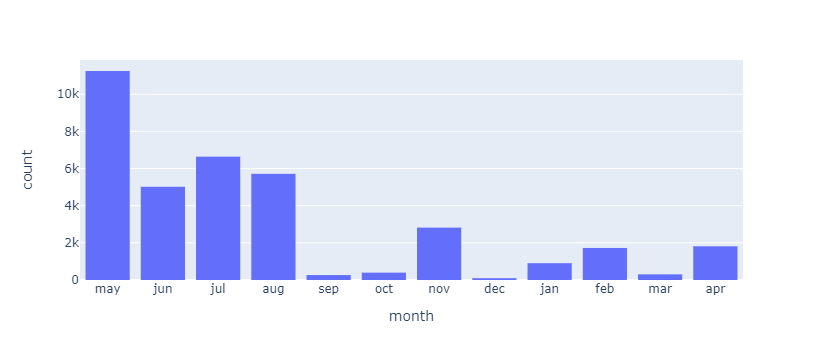

In [32]:
fig = px.histogram(data, x = 'month', category_orders=dict(month=["may", "jun", "jul", "aug", 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']))
fig.show()

As we do not have the data about year of each call, it is not for certain but from this graph we could suppose that in some months, more aggressive campaign were launched - especially in the summer. Adittionaly, the page says that the data are from May 2008 to November 2010, which means that three years of data from May-November are included, while from the other months we do have only two years of data. This might bias the models if a new campaign was launched in some of the underrepresented months in this data, and for this reason I will not use month data in this model.

In [34]:
data.drop(axis = 0, columns = 'month', inplace = True)

In [35]:
# Pivot table for other categorical columns
categorical = ['marital', 'education', 'default', 'housing', 'loan']

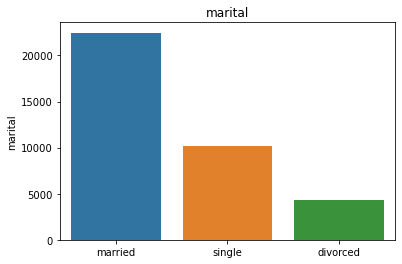

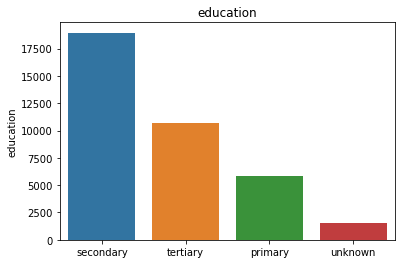

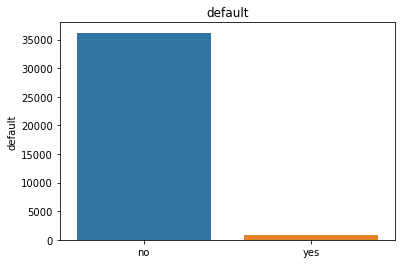

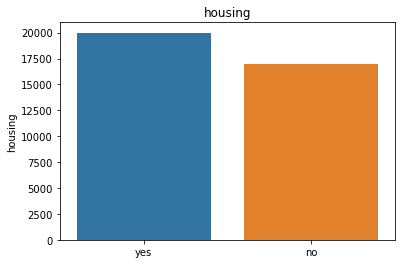

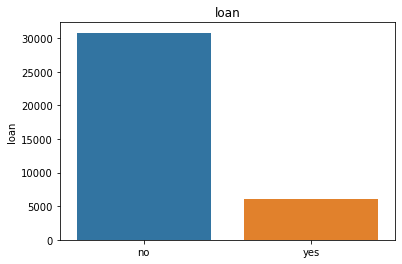

In [21]:
for i in categorical:
    sns.barplot(x=data[i].value_counts().index, y=data[i].value_counts()).set_title(i)
    plt.show()

In [22]:
for i in categorical:
    print(pd.pivot_table(data, index = i, columns = 'y', aggfunc = {'y': 'count'}).droplevel(0, axis = 1))
    print()

y            no   yes
marital              
divorced   3838   438
married   20766  1706
single     8969  1242

y             no   yes
education             
primary     5413   418
secondary  17355  1596
tertiary    9427  1216
unknown     1378   156

y           no   yes
default             
no       32862  3339
yes        711    47

y           no   yes
housing             
no       14868  2101
yes      18705  1285

y        no   yes
loan             
no    27814  3022
yes    5759   364



## 2.2 Numerical data

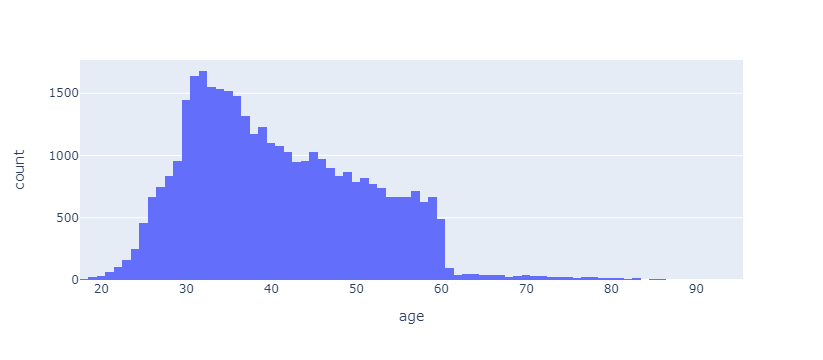

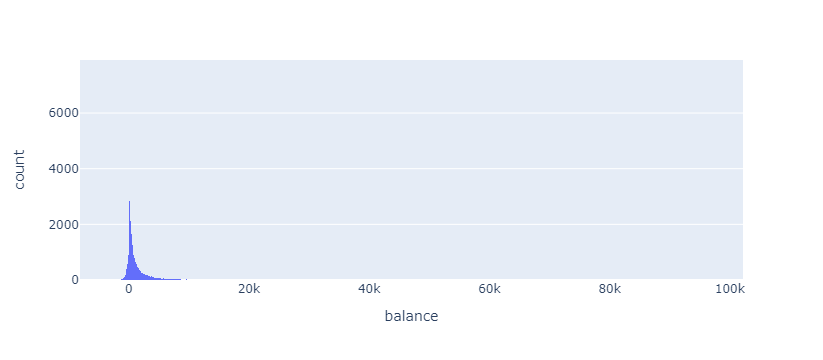

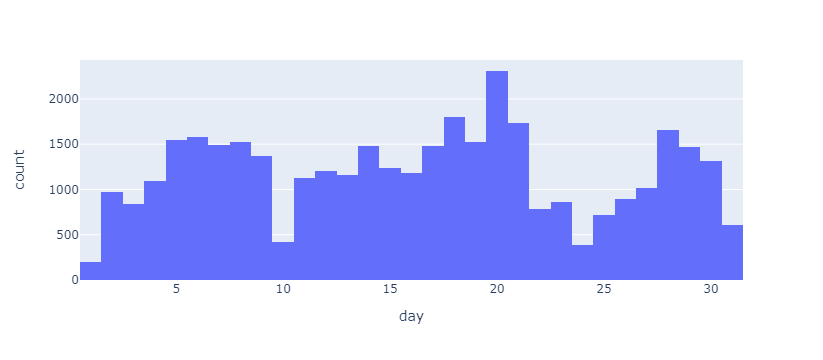

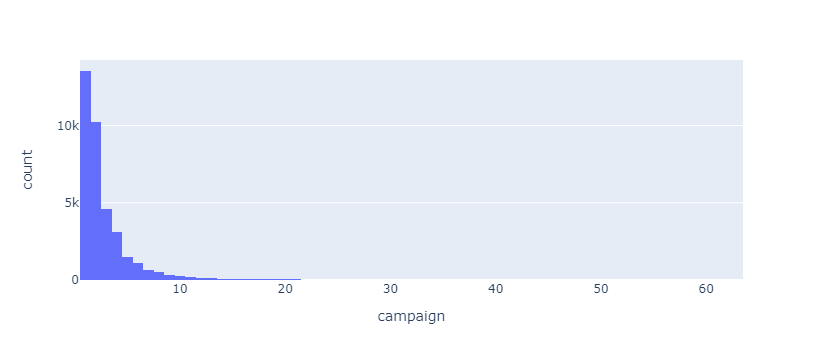

In [36]:
for i in data.select_dtypes('number').columns:
    fig = px.histogram(data, x=i)
    fig.show()

               age   balance       day  campaign
age       1.000000  0.093517 -0.015470  0.005176
balance   0.093517  1.000000 -0.002351 -0.012058
day      -0.015470 -0.002351  1.000000  0.176441
campaign  0.005176 -0.012058  0.176441  1.000000


<AxesSubplot:>

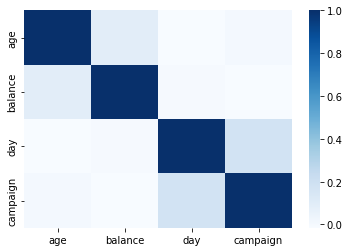

In [37]:
print(data.select_dtypes('number').corr())
sns.heatmap(data.select_dtypes('number').corr(), cmap = 'Blues')

In [38]:
data.describe()

,age,balance,day,campaign
count,36954.000000,36954.000000,36954.000000,36954.000000
mean,40.932430,1318.788846,16.145424,2.921957
std,10.430218,3039.557077,8.372554,3.325791
min,18.000000,-8019.000000,1.000000,1.000000
25%,33.000000,55.000000,9.000000,1.000000
50%,39.000000,414.000000,17.000000,2.000000
75%,49.000000,1358.000000,22.000000,3.000000
max,95.000000,102127.000000,31.000000,63.000000


Minimum and maximum values in age, balance and day columns do seem reasonable. We do have (did have before dropping) month and day at our disposal, but no year is provided so it is impossible to convert the data to dates and see if there are patterns regarding to which days of week are the most successful. 

In [40]:
# the number of contacts in this campaign contains some values that seem
data['campaign'].value_counts()

1     13529
2     10229
3      4608
4      3097
5      1508
6      1128
7       638
8       486
9       303
10      256
11      189
12      148
13      131
14       92
15       83
16       78
17       69
18       51
19       44
20       43
21       35
22       23
25       22
23       22
24       20
29       16
28       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
37        2
50        2
41        2
46        1
58        1
55        1
63        1
51        1
39        1
44        1
Name: campaign, dtype: int64

# 3 Split Data

In [41]:
# Split data into train, validation and test parts
X = data.drop(columns = ['y']).copy()
y = data['y']

# filtrate 70 % as train data
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7)

# test and validation data will be 15% each
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)
print(X_test.shape), print(y_test.shape)

(25867, 11)
(25867,)
(5543, 11)
(5543,)
(5544, 11)
(5544,)


(None, None)

# 4 Feature Engineering

In [42]:
# create list to encode ordinal categories
object_wo_education = ['job', 'marital', 'default', 'housing', 'loan', 'contact']

In [43]:
# map ordinal values in education
feature_order = [{'col':'education',
                  'mapping': {'unknown':0,'primary':1,'secondary':2,'tertiary':3}
                  }]

In [46]:
transformer = ColumnTransformer([
         ('ohe', OneHotEncoder(), object_wo_education),
         ('standard', StandardScaler(), ['age', 'balance', 'day']),
    ('ordinal', OrdinalEncoder(mapping = feature_order,
                               handle_unknown = 'error',
                               handle_missing  = 'error'),
                              ['education']
    ),
         ('winsorizing_and_scaling',
          Pipeline(steps=[
              ('winsorizing', Winsorizer(capping_method = 'quantiles', fold = 0.05, tail = 'right')),
              ('scaling', MinMaxScaler())
          ]), ['campaign']
         )
])

In [47]:
transformer.fit(X_train, y_train)
X_train_transf = transformer.transform(X_train)
X_val_transf = transformer.transform(X_val)
X_test_transf = transformer.transform(X_test)

In [48]:
# I was not able to get names out with get_feature_names_out because of the transformer
# This code is the courtesy of pjgao on github forum: https://github.com/scikit-learn/scikit-learn/issues/12525#issuecomment-436217100
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names_out()
        except AttributeError: 
            names = raw_col_name
        if isinstance(names,np.ndarray): 
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [49]:
# assign column names to X_train_transf
column_names = get_column_names_from_ColumnTransformer(transformer)
print(f'No of column names: {len(column_names)}')
print(f'X_train_transf: {X_train_transf.shape}')

No of column names: 28
X_train_transf: (25867, 29)


In [50]:
column_names

['job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'default_no',
 'default_yes',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'age',
 'balance',
 'day',
 'education']

In [51]:
column_names.append('campaign')

In [52]:
X_train_transf = pd.DataFrame(data = X_train_transf, columns = column_names)

In [53]:
X_val_transf = pd.DataFrame(data = X_val_transf, columns = column_names)
X_test_transf = pd.DataFrame(data = X_test_transf, columns = column_names)

In [54]:
# change output values to 1 for yes an 0 for no
y_train = y_train.map({'yes': 1, 'no': 0}).astype(int)
y_val = y_val.map({'yes': 1, 'no': 0}).astype(int)
y_test = y_test.map({'yes': 1, 'no': 0}).astype(int)

# 5 Model Selection

## 5.1 Decision Tree

In [55]:
dt = DecisionTreeClassifier()
dt.fit(X_train_transf, y_train)

DecisionTreeClassifier()

In [56]:
dt_scores = cross_validate(estimator = dt, X = X_train_transf, y = y_train, 
                           scoring = ['f1','accuracy','precision'], 
                           return_train_score = True,
                           cv = 3)

In [57]:
pd.DataFrame(dt_scores)

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision
0,0.165553,0.015628,0.153935,1.000000,0.829178,1.000000,0.140461,1.0
1,0.138692,0.013004,0.161823,0.999682,0.829390,0.999942,0.146694,1.0
2,0.109370,0.015631,0.147837,0.999682,0.835537,0.999942,0.140251,1.0


The model is overfitted on training data (precision and accuracy on training data is 100%), so I'll try tuning the hyperparametre ccp_alpha.

In [58]:
dt_base_grid = {'ccp_alpha': [0.5, 0.1, 0.01, 0.005, 0.001],
               'max_depth': [None, 2, 3, 4, 5, 6, 7, 8]}
dt_grid = GridSearchCV(dt, dt_base_grid)
dt_grid.fit(X_train_transf, y_train)
print("Best setting discovered: ")
dt_grid.best_estimator_

Best setting discovered: 


DecisionTreeClassifier(ccp_alpha=0.5)

In [59]:
best_dt = dt_grid.best_estimator_
dt_scores_optimized = cross_validate(estimator = best_dt, X = X_train_transf, y = y_train, 
                           scoring = ['f1','accuracy'], 
                           return_train_score = True,
                           cv = 3)

In [60]:
pd.DataFrame(dt_scores_optimized)

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy
0,0.196898,0.015635,0.0,0.0,0.908732,0.908722
1,0.130971,0.007016,0.0,0.0,0.908722,0.908727
2,0.141995,0.015637,0.0,0.0,0.908722,0.908727


The performance improved and is similar for train and test data, so I'll fit the tree. It is also slightly better than in the previous project, where I kept the months parameter and people which were contacted in previous campaigns.

In [61]:
best_dt.fit(X_train_transf, y_train)

DecisionTreeClassifier(ccp_alpha=0.5)

In [62]:
# Evaluate the model on validation data
y_train_pred_dt = best_dt.predict(X_train_transf)
y_val_pred_dt = best_dt.predict(X_val_transf)
print("Accuracy on training data: " + str(round(accuracy_score(y_train, y_train_pred_dt), 2)))
print("Accuracy on validation data: " + str(round(accuracy_score(y_val, y_val_pred_dt), 2)))

Accuracy on training data: 0.91
Accuracy on validation data: 0.91


Accuracy is good on both training and validation data, so I won't tune the hyperparameters anymore and I'll try the model on test data.

In [63]:
y_test_pred_dt = best_dt.predict(X_test_transf)
print("Accuracy on holdout data: " + str(round(accuracy_score(y_test, y_test_pred_dt), 3)))

Accuracy on holdout data: 0.905


## 5.3 Logistic Regression

### 5.3.1 Attribute selection

In [64]:
# Visualize the correlation between numerical attributes
correlation_matrix = X_train.corr()

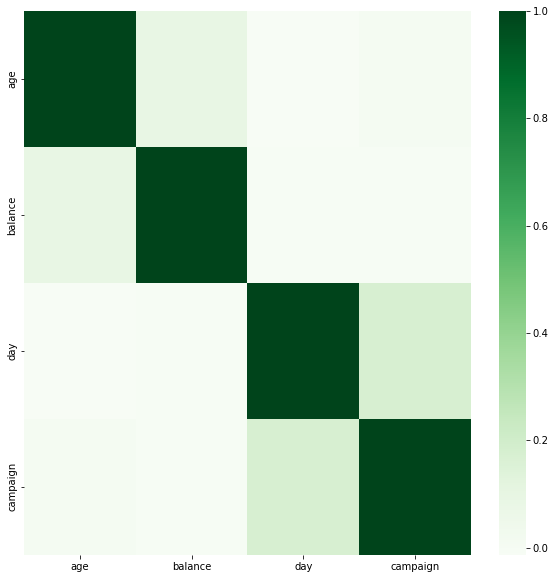

In [65]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, cmap = 'Greens');

The correlation between attributes is not very high, so they are probably informative and I'll keep all of them.

In [66]:
mutual_info = SelectKBest(score_func = mutual_info_classif, k = 'all')
mutual_info.fit(X_train_transf, y_train)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x0000023B9A0F29D0>)

In [67]:
feature_names = X_train_transf.columns[mutual_info.get_support()]
feature_score = mutual_info.scores_

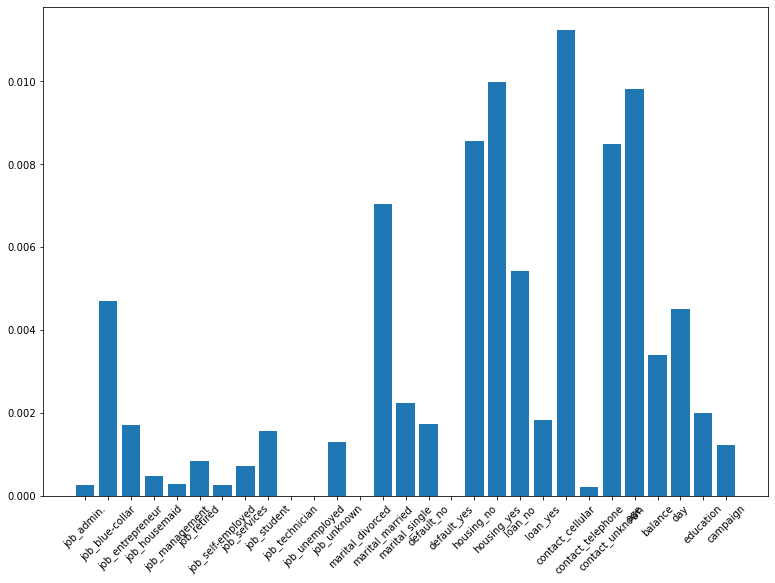

In [68]:
# Creating a visualization
fig, ax = plt.subplots(figsize = (13,9))
ax.bar(feature_names,feature_score)
plt.xticks(rotation = 45);

### 5.3.2 Model creation

In [69]:
lr = LogisticRegression(penalty='elasticnet',
                        solver='saga',
                        max_iter=10000,
                        l1_ratio=0.5,
                        random_state=42,
                        n_jobs=-1)

In [70]:
lr.fit(X_train_transf, y_train)

LogisticRegression(l1_ratio=0.5, max_iter=10000, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')

In [71]:
print(f'train accuracy: {lr.score(X_train_transf, y_train):.3}')
print(f'validation accuracy: {lr.score(X_val_transf, y_val):.3}')

train accuracy: 0.909
validation accuracy: 0.911


In [72]:
# It seems that the best model is with the default threshold, so I'll try it's performance on the holdout data
y_test_pred_lr = lr.score(X_test_transf, y_test)
print(f'holdout accuracy: {y_test_pred_lr:.3}')

holdout accuracy: 0.905


## 5.3 Random Forest

In [73]:
# I'll use ordinal encoder instead of OneHotEncoder for Random Forest to avoid unbalanced tree
# so I'll create a new transformer

rf_pipe = Pipeline(steps=[
                          ('rf_trans',
                           ColumnTransformer([
                                              ('ordinal_other', OrdinalEncoder(), object_wo_education),
                                              ('standard', StandardScaler(), ['age', 'balance', 'day']),
                                              ('ordinal', OrdinalEncoder(mapping = feature_order,
                                                                         handle_unknown = 'error',
                                                                         handle_missing  = 'error'),
                                               ['education']
                                                   ),
                                              ('winsorizing_and_scaling',
                                               Pipeline(steps=[
                                                               ('winsorizing', 
                                                                Winsorizer(capping_method = 'quantiles', 
                                                                           fold = 0.05, 
                                                                           tail = 'right')),
                                                               ('scaling', MinMaxScaler())
                                                                         ]), 
                                               ['campaign']
                                               )
                           ])
                          ),
                          ('rf',
                           RandomForestClassifier())
])


In [74]:
rf_base_scores = cross_validate(estimator = rf_pipe, X = X_train, y = y_train, 
                           scoring = ['f1','accuracy','precision'], 
                           return_train_score = True,
                           cv = 3)
pd.DataFrame(rf_base_scores)

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision
0,2.807333,0.235158,0.046674,0.999364,0.905253,0.999884,0.285714,1.0
1,2.308151,0.357469,0.051103,0.999046,0.905242,0.999826,0.297297,1.0
2,2.580118,0.270987,0.051282,0.999682,0.905590,0.999942,0.309859,1.0


In [75]:
# Note: I ran various grids to find the best hyperparameters, this was the one which was most useful
# the improvement on test data was very minor in all of the though
default_rf_grid = {
                   'rf__max_depth': [6, 8, 10, 12, 14],
                   'rf__max_samples': [0.5, 0.6, 0.8, 0.9],
                   'rf__max_features': ["log2", "sqrt"],
}

In [77]:
grid_rf = GridSearchCV(rf_pipe, default_rf_grid, cv = 3)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('rf_trans',
                                        ColumnTransformer(transformers=[('ordinal_other',
                                                                         OrdinalEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact']),
                                                                        ('standard',
                                                                         StandardScaler(),
                                                                   

In [78]:
grid_rf.best_estimator_

Pipeline(steps=[('rf_trans',
                 ColumnTransformer(transformers=[('ordinal_other',
                                                  OrdinalEncoder(),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan',
                                                   'contact']),
                                                 ('standard', StandardScaler(),
                                                  ['age', 'balance', 'day']),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_missing='error',
                                                                 handle_unknown='error',
                                                                 mapping=[{'col': 'education',
                                                                           'mapping': {'primary': 1,
                             

In [80]:
rf_best = grid_rf.best_estimator_
rf_best_scores = cross_validate(estimator = rf_best, X = X_train, y = y_train, 
                           scoring = ['f1','accuracy'], 
                           return_train_score = True,
                           cv = 5)
pd.DataFrame(rf_best_scores)

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy
0,1.501514,0.125000,0.000000,0.042487,0.908388,0.910694
1,1.393708,0.109371,0.000000,0.022001,0.908388,0.909776
2,1.362690,0.109376,0.004228,0.031266,0.908950,0.910167
3,1.406793,0.124995,0.000000,0.038422,0.908564,0.910505
4,1.372739,0.134667,0.004219,0.030240,0.908757,0.910119


In [81]:
rf_best.fit(X_train, y_train)

Pipeline(steps=[('rf_trans',
                 ColumnTransformer(transformers=[('ordinal_other',
                                                  OrdinalEncoder(),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan',
                                                   'contact']),
                                                 ('standard', StandardScaler(),
                                                  ['age', 'balance', 'day']),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_missing='error',
                                                                 handle_unknown='error',
                                                                 mapping=[{'col': 'education',
                                                                           'mapping': {'primary': 1,
                             

In [82]:
# Evaluate the model on validation data
y_train_pred_rf = rf_best.predict(X_train)
y_val_pred_rf = rf_best.predict(X_val)
print("Accuracy on training data: " + str(round(accuracy_score(y_train, y_train_pred_rf), 3)))
print("Accuracy on validation data: " + str(round(accuracy_score(y_val, y_val_pred_rf), 3)))

Accuracy on training data: 0.91
Accuracy on validation data: 0.911


In [83]:
# As I was unable to get a better performance from the random forest despite running several grids, I'll try the test data
y_test_pred_rf = rf_best.predict(X_test)
print("Accuracy on holdout data: " + str(round(accuracy_score(y_test, y_test_pred_rf), 3)))

Accuracy on holdout data: 0.905


# 6. Comparison of performance

In [85]:
print(f"Decision Tree accuracy on holdout data: {round(accuracy_score(y_test, y_test_pred_dt), 3)}")
print(f"Random Forest accuracy on holdout data: {round(accuracy_score(y_test, y_test_pred_rf), 3)}")
print(f'Logistic Regression accuracy on holdout data: {y_test_pred_lr:.3}')

Decision Tree accuracy on holdout data: 0.905
Random Forest accuracy on holdout data: 0.905
Logistic Regression accuracy on holdout data: 0.905
